In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os

sns.set()

dataPath = '/Users/maxaragon/Desktop/11636748/ibl-behavioral-data-Dec2019'
os.chdir(dataPath)


In [2]:
##Code from IBL 

try:
    from oneibl.onelight import ONE
except ImportError:
    print("Error: Please install ibllib 1.4.7+ with `pip install ibllib`")
    exit()

one = ONE()

# Search all sessions that have these dataset types.
eids = one.search(['_ibl_trials.*'])

# Select the first session.
eid = eids[1]
print(f"Loading session {eid}.")

# List all dataset types available in that session.
dset_types = one.list(eid)

# Loading a single dataset.
choice = one.load_dataset(eid, dset_types[0])

# Loading an object.
print("Loading the _ibl_trials object.")
obj = one.load_object(eid, "_ibl_trials")
print("The example script ran successfully!")


Loading session angelakilab/Subjects/IBL-T1/2019-02-10/001.
Loading the _ibl_trials object.
The example script ran successfully!


In [113]:
def loadData(eids):
    
    '''Extracts data from fully trained animals for each IBL lab.
        
        Inputs
        ------
        eids (list of strings): Contains directories for each experiment
        labs (list of strings): Contains lab names
        
        Outputs
        --------
        data (dict): Contains last day of data for each subject in each lab'''

    data = {}
    names = []
    labs = []
    
    #Get lab names 
    for eid in eids:
        lab = eid.split('/')[0]
        
        if lab not in labs:
            labs.append(lab)
        
    for lab in labs:
        labData = [eid for eid in eids if lab in eid] #all data for each lab
        subjects = [] #subject names

        #Get subject names for each lab
        for file in labData:
            subjects.append(file.split("Subjects")[-1].split('/')[1])
        uSubjs = np.unique(subjects) #unique subject names 

        #Get experiment from last day for each subject (fully-trained animals) 
        for subj in uSubjs:
            subjectData = [file for file in labData if subj in file]
            data[(lab,subj)] = one.load_object(subjectData[-1], '_ibl_trials') #only take data from last day
            names.append((lab,subj))
            
    return data,names,labs

def preprocData(data,names):
    '''Outputs
    ----------
    fullData (dict): One key for each lab. Dict values are lists (#features x #mice x #trials) 
    '''
    
    #Find min trial length across all experiments
    minLen = 10**6 #dummy length
    
    for name in names:
        testLen = len(data[name]['choice'])
        if testLen < minLen:
            minLen = testLen
            
    #Create data matrices
    labNames = np.unique(np.array(names)[:,0])
    fullData = [] #all data
    
    #Initialize arrays
    choiceMat = [] #L,R, or no-go
    levels = [] #indicates the group (lab) to which trial belongs
    choiceAR = [] #shifted choice 
    contrastMat = [] #stimulus contrast
    pleftMat = [] #probability of stim on left side
    prightMat = [] #probability of stim on right side
    fbMat = [] #feedback type 
    sideMat = [] #stimulus location
    
    #Compile data 
    for idx,labName in enumerate(labNames):

        for name in names:
            if labName in name:
                exp = data[name]
                
                expLen = minLen #min(100,len(exp['contrastLeft'])) #experiment length minLen#
                side = [0 if not np.isnan(x) else 1 
                            for x,y in zip(exp['contrastLeft'],exp['contrastRight'])]
                contrast = [x if not np.isnan(x) else y 
                            for x,y in zip(exp['contrastLeft'],exp['contrastRight'])]

                contrastMat.append(contrast[1:expLen])
                sideMat.append(side[1:expLen])
                
                #Process choices 
                choice = exp['choice']
                choice[choice==0] = np.random.choice([-1,1]) #randomly assign "no-go" to left or right (fix later?)
                choice[choice==-1] = 0
                choiceMat.append(choice[1:expLen])
                choiceAR.append(choice[0:expLen-1]) #autoregressive choice
                
                #Feedback
                fb = exp['feedbackType']
                fbMat.append(fb[0:expLen-1])
                
                #Rest of predictors 
                pleftMat.append(exp['probabilityLeft'][1:expLen])
                prightMat.append(1 - exp['probabilityLeft'][1:expLen])
                idxMat = np.zeros(expLen-1)+idx
                levels.append(idxMat)
                
    predictors = (contrastMat,choiceAR,fbMat,sideMat)

    return predictors,choiceMat,levels

#Load data 
data,names,labs = loadData(eids)
#Preprocess data
predictors,choices,levels = preprocData(data,names)
# levels = np.array(levels).astype(int) + 1
numPreds, numMice, numTrials = np.shape(predictors)
predictors = np.reshape(predictors,(-1,numMice*numTrials))
levels = np.reshape(levels,(numMice*numTrials)).astype('int')+1
choices = np.reshape(choices,(numMice*numTrials))

#Create final data structure
fullData = {'D': numPreds,
        'N': len(levels), 
        'L': len(np.unique(levels)), 
        'y': choices, 
        'll': levels, 
        'x': np.array(predictors).T}


In [48]:
#Model with Ting's trick
model = '''
data{
    int<lower=1> D; // num predictors
    int<lower=0> N; // num samples 
    int<lower=1> L; // num groups
    int<lower=0,upper=1> y[N]; //targets
    int<lower=1,upper=L> ll[N]; //levels
    row_vector[D] x[N]; //predictors

}
parameters {
    real alpha[L];
    vector[D] mu; // population mean for parameters  
    real<lower=0> sigma[D]; //population std for parameters  
    vector[D] beta[L]; //regression coefficients for each predictor in each level 
}

model {
    for (d in 1:D){
        
        for (l in 1:L)
            beta[l,d] ~ normal(0, sigma[d]);
  }
  
    for (n in 1:N)
        y[n] ~ bernoulli(inv_logit(alpha[ll[n]] + x[n] * (beta[ll[n]] + mu)));
}
        '''

In [49]:
import pystan

#Compile model
sm = pystan.StanModel(model_code=model)

#Sample from posterior
fit = sm.sampling(data=fullData, iter=1000, chains=4, warmup=500, thin=1, seed=101)
#control = {'adapt_delta':0.95, 'max_treedepth':10}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bc49f135103c81fe3cb57e9536f7e2fd NOW.


In [50]:
print(fit)

Inference for Stan model: anon_model_bc49f135103c81fe3cb57e9536f7e2fd.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%     50%     75%  97.5%  n_eff   Rhat
alpha[1]    0.05  4.2e-3   0.19  -0.31  -0.08    0.05    0.18   0.43   2048    1.0
alpha[2]   -0.57  3.8e-3   0.17   -0.9  -0.68   -0.56   -0.45  -0.25   1981    1.0
alpha[3]    0.85  3.8e-3   0.17   0.54   0.74    0.85    0.96   1.19   1953    1.0
alpha[4]    1.15  5.3e-3   0.23   0.71   0.98    1.15    1.31   1.61   1933    1.0
alpha[5]    0.62  6.3e-3   0.25   0.13   0.45    0.63    0.79   1.11   1597    1.0
alpha[6]    1.38  3.7e-3   0.18   1.03   1.26    1.38    1.49   1.72   2220    1.0
alpha[7]    0.84  5.0e-3   0.23   0.38   0.68    0.83     1.0   1.29   2175    1.0
alpha[8]    0.91  3.6e-3   0.19   0.52   0.78    0.91    1.04   1.28   2822    1.0
alpha[9]    0.64  4.5e-3    0.2   0.25    0.5    0.63    0.77   1.

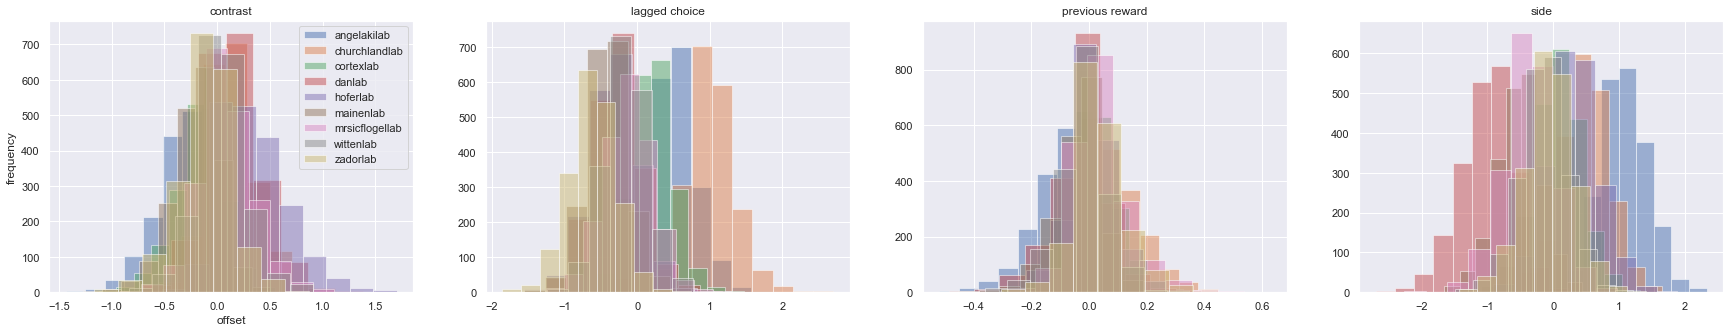

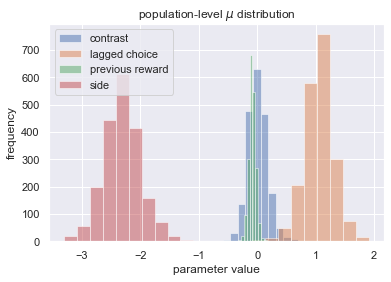

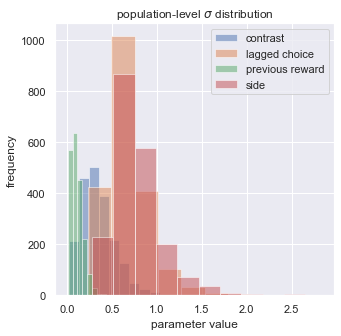

In [58]:

betas = fit['beta']
betas = betas.T
mus = fit['mu']
mus = mus.T
sigmas = fit['sigma']
sigmas = sigmas.T

betaLabels = ['contrast','lagged choice','previous reward','side']

#Plot beta distributions across labs
fig,ax = plt.subplots(1,len(betaLabels),figsize = (30,5))

for idx0, beta in enumerate(betas):
    
    for idx1,lab in enumerate(beta):
        ax[idx0].hist(lab,alpha=0.5,label = labs[idx1])
    
    ax[idx0].set_title(betaLabels[idx0])
    
    if idx0==0:
        ax[idx0].legend()
        ax[idx0].set_xlabel('offset')
        ax[idx0].set_ylabel('frequency')

plt.show()

#Look at distribution of fixed effects means
#fig,ax = plt.subplots(figsize = (5,5))

for idx0, mu in enumerate(mus):
    plt.hist(mu,alpha=0.5,label=betaLabels[idx0])
    plt.title('population-level $\mu$ distribution')
    plt.xlabel('parameter value')
    plt.ylabel('frequency')

plt.legend()
plt.show()
    

#Look at distribution of fixed effects sigma
fig,ax = plt.subplots(figsize = (5,5))

for idx0, sig in enumerate(sigmas):
    ax.hist(sig,alpha=0.5,label = betaLabels[idx0])
    ax.set_title('population-level $\sigma$ distribution')
    if idx0==0:
        ax.set_xlabel('parameter value')
        ax.set_ylabel('frequency')
    ax.legend()

plt.show()
    

In [53]:
from pystan import diagnostics
checks = ["divergence", "treedepth", "energy"]
pystan.diagnostics.check_hmc_diagnostics(fit, checks=checks)

{'divergence': True, 'treedepth': True, 'energy': True}

In [ ]:
import pickle 

with open('/Users/maxaragon/Desktop/model_fit.pkl', 'wb') as f:
    pickle.dump([model,fit], f, protocol=-1)



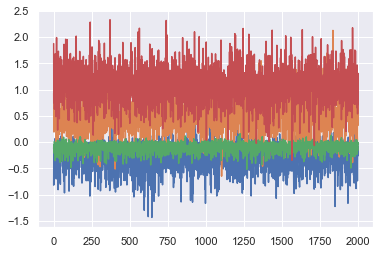

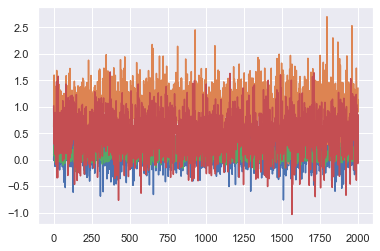

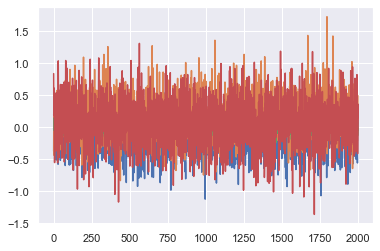

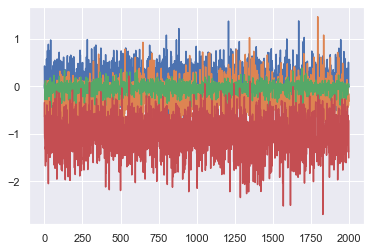

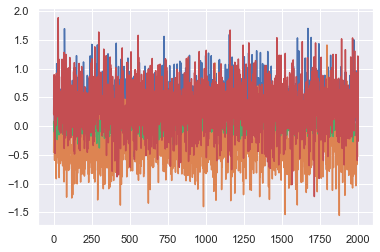

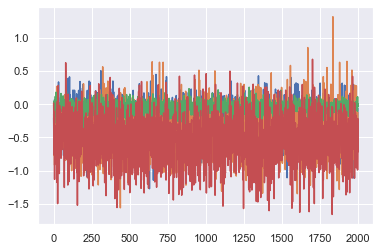

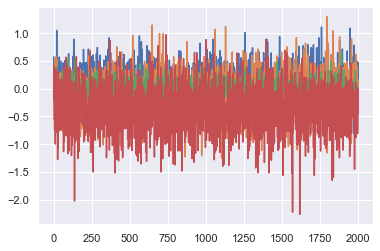

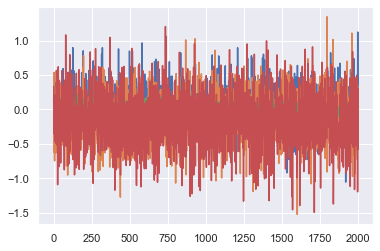

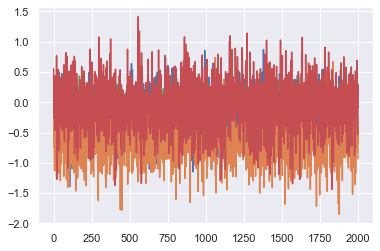

In [66]:
#Plot some parameter sampling examples

for i in range(9):
    q = betas[:,i,:]
    plt.plot(q.T)
    plt.show()

0.3798449612403101
0.32558139534883723
0.27180232558139533
0.15762273901808785
0.29069767441860467
0.20195838433292534
0.22259136212624583
0.23678646934460887
0.25290697674418605


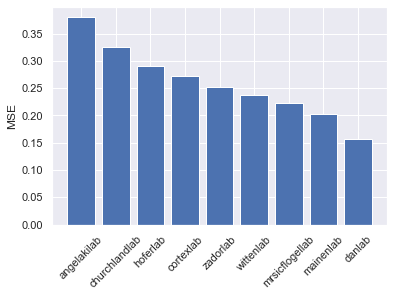

In [128]:

#Calculate mouse performance 
side = predictors[-1,:]

labNum = np.arange(9)+1

MSEs = []

for l in labNum:
    labIdx = np.where(np.array(levels)==l)
    labSide = np.abs(side[labIdx]-1)
    labChoice = choices[labIdx]

    MSE = 0

    for s,l in zip(labSide,labChoice):
        MSE+=(s-l)**2
    
    MSE/=len(labSide)
    MSEs.append(MSE)
    
    print(MSE)

sortIdx = np.argsort(MSEs)
labSort = np.flip(np.array(labs)[sortIdx])
plt.bar(labSort,np.flip(np.sort(MSEs)))
plt.xticks(rotation=45)
plt.ylabel('MSE')
plt.show()